In [ ]:
import numpy as np
import cv2

def singleScaleRetinex(img, sigma):

    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), sigma))

    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def colorRestoration(img, alpha, beta):

    img_sum = np.sum(img, axis=2, keepdims=True)

    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    return color_restoration

def simplestColorBalance(img, low_clip, high_clip):    

    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):            
            if float(current) / total < low_clip:
                low_val = u
            if float(current) / total < high_clip:
                high_val = u
            current += c
                
        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

    return img    

def MSRCR(img, sigma_list, G, b, alpha, beta, low_clip, high_clip):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)    
    img_color = colorRestoration(img, alpha, beta)    
    img_msrcr = G * (img_retinex * img_color + b)

    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                             (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                             255
    
    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr = simplestColorBalance(img_msrcr, low_clip, high_clip)       

    return img_msrcr

def automatedMSRCR(img, sigma_list):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break
            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break
            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255

    img_retinex = np.uint8(img_retinex)
        
    return img_retinex

def MSRCP(img, sigma_list, low_clip, high_clip):

    img = np.float64(img) + 1.0

    intensity = np.sum(img, axis=2) / img.shape[2]    

    retinex = multiScaleRetinex(intensity, sigma_list)

    intensity = np.expand_dims(intensity, 2)
    retinex = np.expand_dims(retinex, 2)

    intensity1 = simplestColorBalance(retinex, low_clip, high_clip)

    intensity1 = (intensity1 - np.min(intensity1)) / \
                 (np.max(intensity1) - np.min(intensity1)) * \
                 255.0 + 1.0

    img_msrcp = np.zeros_like(img)
    
    for y in range(img_msrcp.shape[0]):
        for x in range(img_msrcp.shape[1]):
            B = np.max(img[y, x])
            A = np.minimum(256.0 / B, intensity1[y, x, 0] / intensity[y, x, 0])
            img_msrcp[y, x, 0] = A * img[y, x, 0]
            img_msrcp[y, x, 1] = A * img[y, x, 1]
            img_msrcp[y, x, 2] = A * img[y, x, 2]

    img_msrcp = np.uint8(img_msrcp - 1.0)

    return img_msrcp

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_rose.zip' './'

In [ ]:
!unzip data_raw_rose.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test71.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test27.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test4.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test81.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test43.jpg  
   creating: data/imposter/Mf_NT_5s_wg_E_10_45/
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test9.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test26.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test24.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test37.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test12.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test36.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test16.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test76.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test62.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test55.jpg 

In [ ]:
config = {
    "sigma_list": [15, 80, 250],
    "G"         : 5.0,
    "b"         : 25.0,
    "alpha"     : 125.0,
    "beta"      : 46.0,
    "low_clip"  : 0.01,
    "high_clip" : 0.99
}

In [ ]:
img = cv2.imread('/content/data/client/G_NT_5s_g_E_11_1/test0.jpg')

In [ ]:
img_msrcr = MSRCR(
    img,
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

In [ ]:
import matplotlib.pyplot as plt

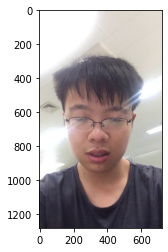

In [ ]:
plt.imshow(img[...,::-1])

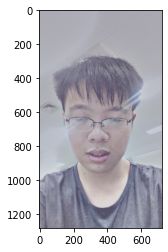

In [ ]:
plt.imshow(img_msrcr[...,::-1])

In [ ]:
imposter_img = cv2.imread('/content/data/imposter/Vm_NT_5s_g_E_11_160/test0.jpg')

In [ ]:
imposter_img_msr = MSRCR(
    imposter_img,
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

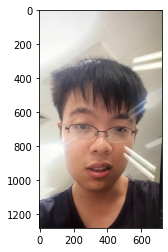

In [ ]:
plt.imshow(imposter_img[...,::-1])

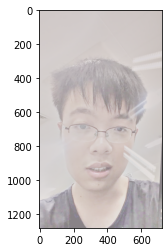

In [ ]:
plt.imshow(imposter_img_msr[...,::-1])

In [ ]:
from glob import glob

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/client_rose_raw.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/imposter_rose_raw.txt' './'

In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

--2021-05-28 16:09:06--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  12.5MB/s    in 4.0s    

2021-05-28 16:09:10 (15.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import random
from scipy.stats import norm
import tqdm
INPUT_SIZE = 112


# TEst

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
img = cv2.imread('/content/data/client/G_NT_5s_g_E_11_1/test0.jpg')

In [ ]:
Y, X, C = img.shape
X, Y, C

(720, 1280, 3)

In [ ]:
dets = detector(img[...,::-1])
if dets:
  max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
  d = dets[0]
  if len(dets) > 1:
    for dz in dets[1:]:
      h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
      if h > max_a:
        d = dz

In [ ]:
size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
min_ = min(size)
min_

156

In [ ]:
img = cv2.rectangle(img, (d.left()-min_,d.top()-min_), (d.right()+min_,d.bottom()+min_),(255,0,0),5)

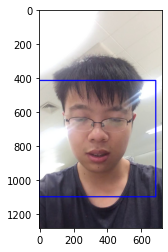

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[...,::-1])

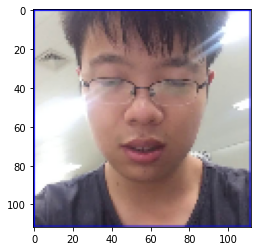

In [ ]:
test = cv2.resize(img[d.top()-min_:d.bottom()+min_,d.left()-min_:d.right()+min_,::-1], (112,112))
import matplotlib.pyplot as plt
plt.imshow(test)

In [ ]:
test_mrs = MSRCR(
    test[...,::-1],
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

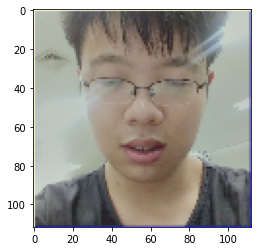

In [ ]:
plt.imshow(test_mrs[...,::-1])

In [ ]:
def create_box_rgb(img):
  Y, X, C = img.shape
  dets = detector(img)
  flag = False
  if dets:
    max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
    d = dets[0]
    if len(dets) > 1:
      for dz in dets[1:]:
        h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
        if h > max_a:
          d = dz
    size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
    min_ = min(size)
    return (d.top()-min_,d.bottom()+min_,d.left()-min_,d.right()+min_), flag
  else:
    flag = True
    return None, flag

In [ ]:
def crop_rgb(img, box):
  top, bottom, left, right = box
  img = img[top:bottom, left:right]
  dets = detector(img)
  flag = False
  if dets:
    try:
      img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
      temp = MSRCR(
          img[...,::-1],
          config['sigma_list'],
          config['G'],
          config['b'],
          config['alpha'],
          config['beta'],
          config['low_clip'],
          config['high_clip']
      )
    except Exception as e:
      flag = True
    if flag:
      return None, flag
    else:
      return temp, flag
  else:
    return None, True


In [ ]:
def calculate_optical_flow(old, new):
  # old = old[...,::-1]
  # new = new[...,::-1]
  old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
  new_gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(old_gray, new_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
  return flow

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = []
for name in os.listdir('/content/data/imposter'):
    imposter_dataset.append(name)

In [ ]:
X_5_imposter = []
X_10_imposter = []
X_15_imposter = []
X_20_imposter = []
imagePaths = list(map(lambda x: x.rstrip(),open('imposter_rose_raw.txt').readlines()))
for key in tqdm.tqdm(imposter_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            print('OK')
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5_imposter.append(flow_5)
            X_10_imposter.append(flow_10)
            X_15_imposter.append(flow_15)
            X_20_imposter.append(flow_20)

In [ ]:
X_5_imposter = np.array(X_5_imposter)
X_10_imposter = np.array(X_10_imposter)
X_15_imposter = np.array(X_15_imposter)
X_20_imposter = np.array(X_20_imposter)
X_5_imposter.shape, X_10_imposter.shape, X_15_imposter.shape, X_20_imposter.shape

((18168, 112, 112, 2),
 (18168, 112, 112, 2),
 (18168, 112, 112, 2),
 (18168, 112, 112, 2))

In [ ]:
with open('X_5_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_5_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_10_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_15_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_20_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/X_5_imposter_rose_retinex.pickle'

In [ ]:
!cp 'X_10_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/X_10_imposter_rose_retinex.pickle'

In [ ]:
!cp 'X_15_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/X_15_imposter_rose_retinex.pickle'

In [ ]:
!cp 'X_20_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/X_20_imposter_rose_retinex.pickle'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/data_video.zip' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/client.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/imposter.txt' './'

In [ ]:
!unzip data_video.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_387.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_332.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_445.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_170.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_350.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_206.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_297.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_189.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_314.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_0.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_69.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_481.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_134.jpg  
  inflating: data_video/impos

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
client_dataset = []
for name in os.listdir('/content/data_video/client'):
    client_dataset.append(name)

In [ ]:
X_5 = []
X_10 = []
X_15 = []
X_20 = []
imagePaths = list(map(lambda x: x.rstrip(),open('client.txt').readlines()))
for key in tqdm.tqdm(client_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            # print('OK')
            old_flip = cv2.flip(old, 1)
            new_5_flip = cv2.flip(new_5, 1)
            new_10_flip = cv2.flip(new_10, 1)
            new_15_flip = cv2.flip(new_15, 1)
            new_20_flip = cv2.flip(new_20, 1)
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5.append(flow_5)
            X_10.append(flow_10)
            X_15.append(flow_15)
            X_20.append(flow_20)
            flow_5 = calculate_optical_flow(old_flip, new_5_flip)
            flow_10 = calculate_optical_flow(old_flip, new_10_flip)
            flow_15 = calculate_optical_flow(old_flip, new_15_flip)
            flow_20 = calculate_optical_flow(old_flip, new_20_flip)
            X_5.append(flow_5)
            X_10.append(flow_10)
            X_15.append(flow_15)
            X_20.append(flow_20)



  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [01:22<33:10, 82.93s/it]

  8%|▊         | 2/25 [01:56<26:09, 68.22s/it]

 12%|█▏        | 3/25 [07:42<55:33, 151.50s/it]

 16%|█▌        | 4/25 [14:06<1:17:23, 221.13s/it]

 20%|██        | 5/25 [19:53<1:26:18, 258.91s/it]

 24%|██▍       | 6/25 [21:17<1:05:24, 206.53s/it]

 28%|██▊       | 7/25 [22:04<47:36, 158.67s/it]  

 32%|███▏      | 8/25 [23:32<38:55, 137.38s/it]

 36%|███▌      | 9/25 [30:02<56:53, 213.33s/it]

 40%|████      | 10/25 [31:29<43:47, 175.17s/it]

 44%|████▍     | 11/25 [32:54<34:36, 148.29s/it]

 48%|████▊     | 12/25 [34:05<27:07, 125.22s/it]

 52%|█████▏    | 13/25 [40:22<40:08, 200.72s/it]

 56%|█████▌    | 14/25 [41:57<30:57, 168.86s/it]

 60%|██████    | 15/25 [43:32<24:26, 146.65s/it]

 64%|██████▍   | 16/25 [49:44<32:08, 214.24s/it]

 68%|██████▊   | 17/25 [55:54<34:48, 261.08s/it]

 72%|███████▏  | 18/25 [56:38<22:51, 195.98s/it]

 76%|███████▌  | 19/25 [57:58<16:06, 161.09s/it]

 80%|██████

In [ ]:
X_5 = np.array(X_5)
X_10 = np.array(X_10)
X_15 = np.array(X_15)
X_20 = np.array(X_20)
X_5.shape, X_10.shape, X_15.shape, X_20.shape

((9222, 112, 112, 2),
 (9222, 112, 112, 2),
 (9222, 112, 112, 2),
 (9222, 112, 112, 2))

In [ ]:
with open('X_5_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_10, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_15, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_20, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'